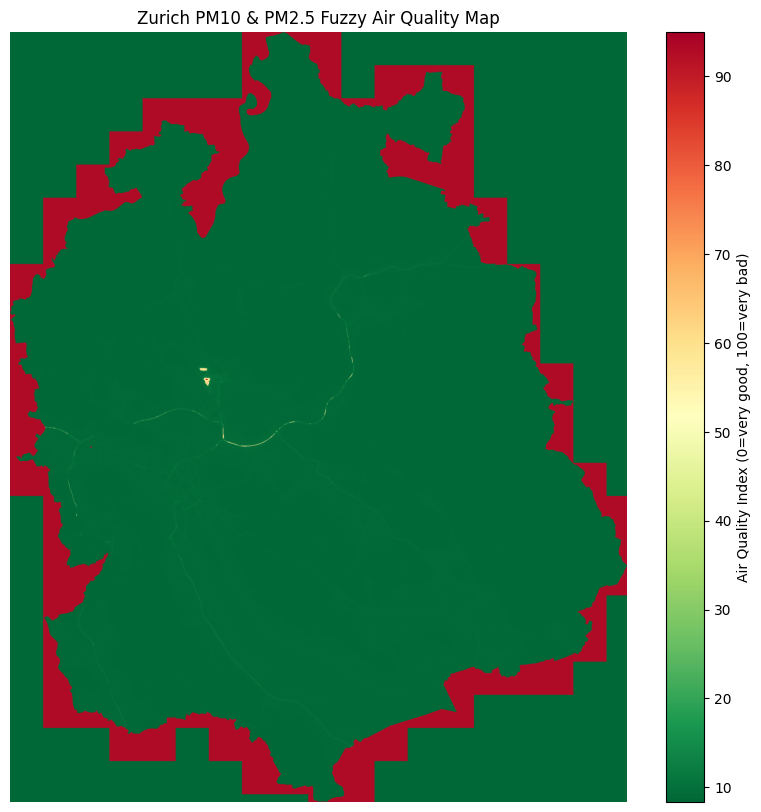

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# --- CONFIGURATION FOR FUZZY VARIABLES ---
# Format: input_file, max_value, variable_name, [good_range], [moderate_range], [bad_range]
# TODO: Filter 0 and for russ 32767 (max 377)
fuzzy_inputs = [
    	{
        "input_file": "../geoserver_data/data/pm10.tif",
        "max_value": 400,
        "name": "pm10",
        "good": [0, 0, 160],
        "moderate": [150, 230, 310],
        "bad": [300, 320, 400]
    },
	 {
        "input_file": "../geoserver_data/data/pm25.tif",
        "max_value": 400,
        "name": "pm25",
        "good": [0, 0, 80],
        "moderate": [75, 160, 235],
        "bad": [200, 240, 400]
    },
	{
        "input_file": "../geoserver_data/data/russ.tif",
        "max_value": 35000,
        "name": "russ",
        "good": [0, 0, 209],
        "moderate": [205, 281, 356],
        "bad": [350, 360, 35000]
    }
]

# --- LOAD RASTERS ---
rasters = {}
meta = None

for var in fuzzy_inputs:
    with rasterio.open(var["input_file"]) as src:
        data = src.read(1).astype(float)
        rasters[var["name"]] = data
        if meta is None:
            meta = src.meta.copy()  # preserve geospatial info

# --- CREATE FUZZY VARIABLES ---
antecedents = {}

for var in fuzzy_inputs:
    ant = ctrl.Antecedent(np.linspace(0, var["max_value"], var["max_value"] + 1), var["name"])
    ant['good'] = fuzz.trimf(ant.universe, var['good'])
    ant['moderate'] = fuzz.trimf(ant.universe, var['moderate'])
    ant['bad'] = fuzz.trimf(ant.universe, var['bad'])
    antecedents[var['name']] = ant

# --- CONSEQUENT ---
quality = ctrl.Consequent(np.linspace(0, 100, 101), 'quality')
quality['very_good'] = fuzz.trimf(quality.universe, [0, 0, 25])
quality['good'] = fuzz.trimf(quality.universe, [20, 40, 60])
quality['liveable'] = fuzz.trimf(quality.universe, [50, 60, 70])
quality['bad'] = fuzz.trimf(quality.universe, [65, 80, 90])
quality['very_bad'] = fuzz.trimf(quality.universe, [85, 100, 100])

# --- DEFINE RULES ---
rules = [
    ctrl.Rule(antecedents['russ']['good'], quality['very_good']),
    ctrl.Rule(antecedents['russ']['moderate'], quality['liveable']),
    ctrl.Rule(antecedents['russ']['bad'], quality['very_bad']),
]

quality_ctrl = ctrl.ControlSystem(rules)
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)

# --- APPLY FUZZY SYSTEM PIXEL-WISE ---
fuzzy_map = np.zeros_like(next(iter(rasters.values())), dtype=float)

# Flatten data for faster computation
flat_data = {}
for var in fuzzy_inputs:
    flat_data[var["name"]] = rasters[var["name"]].flatten()

first_key = next(iter(flat_data))
flat_result = np.zeros_like(flat_data[first_key], dtype=float)

for i in range(flat_data[first_key].size):
    for var in fuzzy_inputs:
        quality_sim.input[var["name"]] = flat_data[var["name"]][i]

    try:
        quality_sim.compute()
        flat_result[i] = quality_sim.output['quality']
    except KeyError:
        print(f"No output for pixel {i} with value {flat_data['russ'][i]}")
        print(f"Quality_sim: {quality_sim}")
        flat_result[i] = np.nan

fuzzy_map = flat_result.reshape(rasters[first_key].shape)

# --- SAVE AS TIF ---
output_file = "../geoserver_data/data/zurich_fuzzy_quality.tif"
meta.update(dtype=rasterio.float32, count=1)
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(fuzzy_map.astype(rasterio.float32), 1)

# --- PLOT FUZZY MAP ---
plt.figure(figsize=(10, 10))
plt.imshow(fuzzy_map, cmap='RdYlGn_r')  # red=bad, green=good
plt.colorbar(label='Air Quality Index (0=very good, 100=very bad)')
plt.title("Zurich PM10 & PM2.5 Fuzzy Air Quality Map")
plt.axis("off")
plt.show()
